In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [18]:
year = input("Which year should we visualize? ")
if year == "all":
    dfs = []
    for path in Path("data").glob("2*.csv"):
        with path.open() as f:
            df = pd.read_csv(f)
            dfs.append(df)
    
    df = pd.concat(dfs, ignore_index=True)
    df = df.drop("Rk", axis=1)
    df.reset_index()
else:
    year = int(year)
    year_plus_1 = str((year + 1) % 100)[-2:]
    year_str = f"{year}{year_plus_1}"
    print(f"Load year {year_str}...")
    df = pd.read_csv(f"data/{year_str}.csv")
    df = df.drop("Rk", axis=1)
df


Load year 202021...


,Player,Age,Tm,Pos,GP,G,A,PTS,+/-,PIM,...,S,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,PlayerID
0,Vitaly Abramov,22,OTT,RW,2,0,0,0,0,0,...,0,NaN,19,9:43,0,0,0,0,NaN,abramvi01
1,Noel Acciari,29,FLA,C,41,4,7,11,0,9,...,68,5.9,631,15:24,63,91,272,247,52.4,acciano01
2,Calen Addison,20,MIN,D,3,0,0,0,0,0,...,4,0.0,56,18:31,1,2,0,0,NaN,addisca01
3,Kenny Agostino,28,TOR,LW,1,0,0,0,0,0,...,0,NaN,4,4:08,0,0,0,0,NaN,agostke01
4,Andrew Agozzino,30,ANA,LW,3,0,1,1,0,0,...,3,0.0,37,12:11,7,6,16,16,50.0,agozzan01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,Mika Zibanejad,27,NYR,C,56,24,26,50,2,18,...,171,14.0,1126,20:06,44,75,479,555,46.3,zibanmi01
1026,Radim Zohorna,24,PIT,F,8,2,2,4,4,4,...,8,25.0,72,9:02,0,7,5,3,62.5,zohorra01
1027,Artem Zub,25,OTT,D,47,3,11,14,4,26,...,39,7.7,864,18:23,70,89,0,0,NaN,zubar01
1028,Mats Zuccarello,33,MIN,LW,42,11,24,35,9,8,...,74,14.9,701,16:41,19,12,11,21,34.4,zuccama01


In [19]:
# Test whether an array consists of integers
def check_integer(x):
    x_rounded = np.round(x)
    return np.all(x_rounded == x)

# Test whether an array has only nonnegative elements
def check_nonnegative(x):
    x = np.array(x)
    return np.all(x >= 0)

# Test
check_integer([1.0,23]), check_integer([1.1,23]), check_nonnegative([1.1,23]), check_nonnegative([1.1,-3])

(True, False, True, False)

In [28]:
stat_rows = []
for column in df.columns:
    vals = np.array(df[column])
    if np.issubdtype(vals.dtype, np.number):
        df_not_null = df[df[column].notnull()]
        vals = np.array(df_not_null[column])
        unique, counts = np.unique(vals, return_counts=True)
        value_counts = dict(zip(unique, counts))
        zero_counts = value_counts.get(0, 0)
        stat_rows.append([column, check_integer(vals), check_nonnegative(vals),
                          len(df_not_null), np.mean(vals), np.std(vals), np.max(vals), np.min(vals),
                          zero_counts / len(df_not_null)])
    else:
        pass
        #print("Non-numeric type")
def get_model(integer, nonnegative, max, min):
    # Count value
    if integer and nonnegative:
        if min < 2:
            return "neg-binomial"
        else:
            return "gaussian"
    
    # Percentage score
    if not integer and nonnegative and max == 100:
        return "beta"
    
    # Nonnegative
    if not integer and nonnegative:
        return "lognormal"
    
    # Default
    return "gaussian"

stat_df = pd.DataFrame(stat_rows, columns = ["stat", "integer", "nonnegative", "len", "mean", "std", "max", "min", "zeros"])
#stat_df["model"] = stat_df.apply(lambda row: get_model(row["integer"], row["nonnegative"], row["max"], row["min"]), axis=1)
stat_df.to_csv("stat_covariates.csv", index=False, float_format='%g')
stat_df

,stat,integer,nonnegative,len,mean,std,max,min,zeros
0,Age,True,True,1030,26.398058,4.054818,43.0,18.0,0.000000
1,GP,True,True,1030,32.500000,19.554393,57.0,1.0,0.000000
2,G,True,True,1030,5.127184,6.204159,41.0,0.0,0.262136
3,A,True,True,1030,8.622330,9.404197,72.0,0.0,0.161165
4,PTS,True,True,1030,13.749515,14.609459,105.0,0.0,0.126214
5,+/-,True,False,1030,-0.504854,8.629565,30.0,-36.0,0.095146
6,PIM,True,True,1030,14.254369,13.907020,96.0,0.0,0.133981
7,PS,False,False,1030,1.606990,1.963514,13.0,-1.1,0.074757
8,EV,True,True,1030,4.006796,4.596427,31.0,0.0,0.270874
9,PP,True,True,1030,0.993204,2.024355,15.0,0.0,0.673786


In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
print(df.columns)
def on_change(x):
    sns.set_theme()
    return sns.displot(df, x=x, kde=True)

interact(on_change, x=list(df.columns)[1:])

Index(['Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'PS',
       'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI',
       'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%'],
      dtype='object')


interactive(children=(Dropdown(description='x', options=('Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PI…

<function __main__.on_change(x)>

<AxesSubplot:>

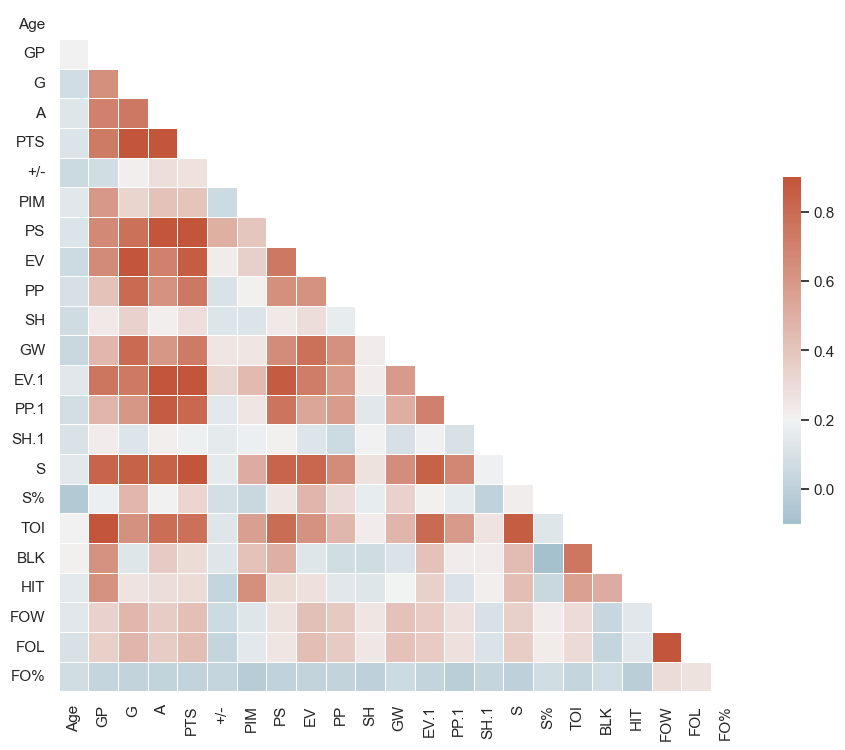

In [26]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0.2,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})